### 3. **Polynomial Regression**

On this model, we will use just one feature to predict the target variable. The feature used is the 'Weight' variable, which seems to have a non-linear relationship with the 'Width' variable.


In [21]:
# Append the path to useful directories
import sys
sys.path.append('../my_functions')

# Packages needed
from download_dataset import download_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Download and extract the dataset
fishcatch = download_dataset(data_file='fishcatch', extension='.tar.xz')

# Quick peek at the data
df = pd.read_csv(fishcatch)
df.head(3).style.background_gradient(cmap='viridis')

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.000000,23.200000,25.400000,30.000000,11.520000,4.020000
1,Bream,290.000000,24.000000,26.300000,31.200000,12.480000,4.305600
2,Bream,340.000000,23.900000,26.500000,31.100000,12.377800,4.696100


In [22]:
# Splitting the dataset into feature and target variable
X = df['Weight']
y = df['Width']

In [23]:
# PolynomialFeatures (preprocessing)
from sklearn.preprocessing import PolynomialFeatures

# Transforming the feature to the desired degree
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X.values.reshape(-1, 1))

In [24]:
# Split the dataset into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [25]:
# Linear model to fit the polynomial features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
# Training R2 score
train_r2 = lr.score(X_train, y_train)
print(f'Training R²: {train_r2:.2f}')

Training R²: 0.90


In [27]:
# Predicting the model
y_pred = lr.predict(X_test)
y_pred

array([2.79677666, 2.28268616, 3.68887447, 4.15422108, 3.3357194 ,
       6.98603016, 2.23018202, 3.54968891, 3.60569537, 7.10793846,
       6.08859626, 6.98603016, 5.89117596, 3.3357194 , 6.2687127 ,
       6.85565511, 6.98603016, 3.81177431, 3.85896306, 6.2687127 ,
       2.25482863, 5.93204433, 5.44442377, 5.44442377, 6.91814491,
       7.08670507, 3.47905789, 4.15422108, 2.22771393, 2.25400808,
       5.49221369, 2.73467924])

In [28]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.43645912385487384
Root Mean Squared Error: 0.6606505308064725
Mean Absolute Error: 0.552790892741206
R2 Score: 0.8756130321661089


In [29]:
# Save the results to a csv file
from save_results import save_results
save_results(mse, mae, r2, rmse, train_r2, 'Polynomial Regression: Weight vs Width')

Results saved successfully to "results.csv".


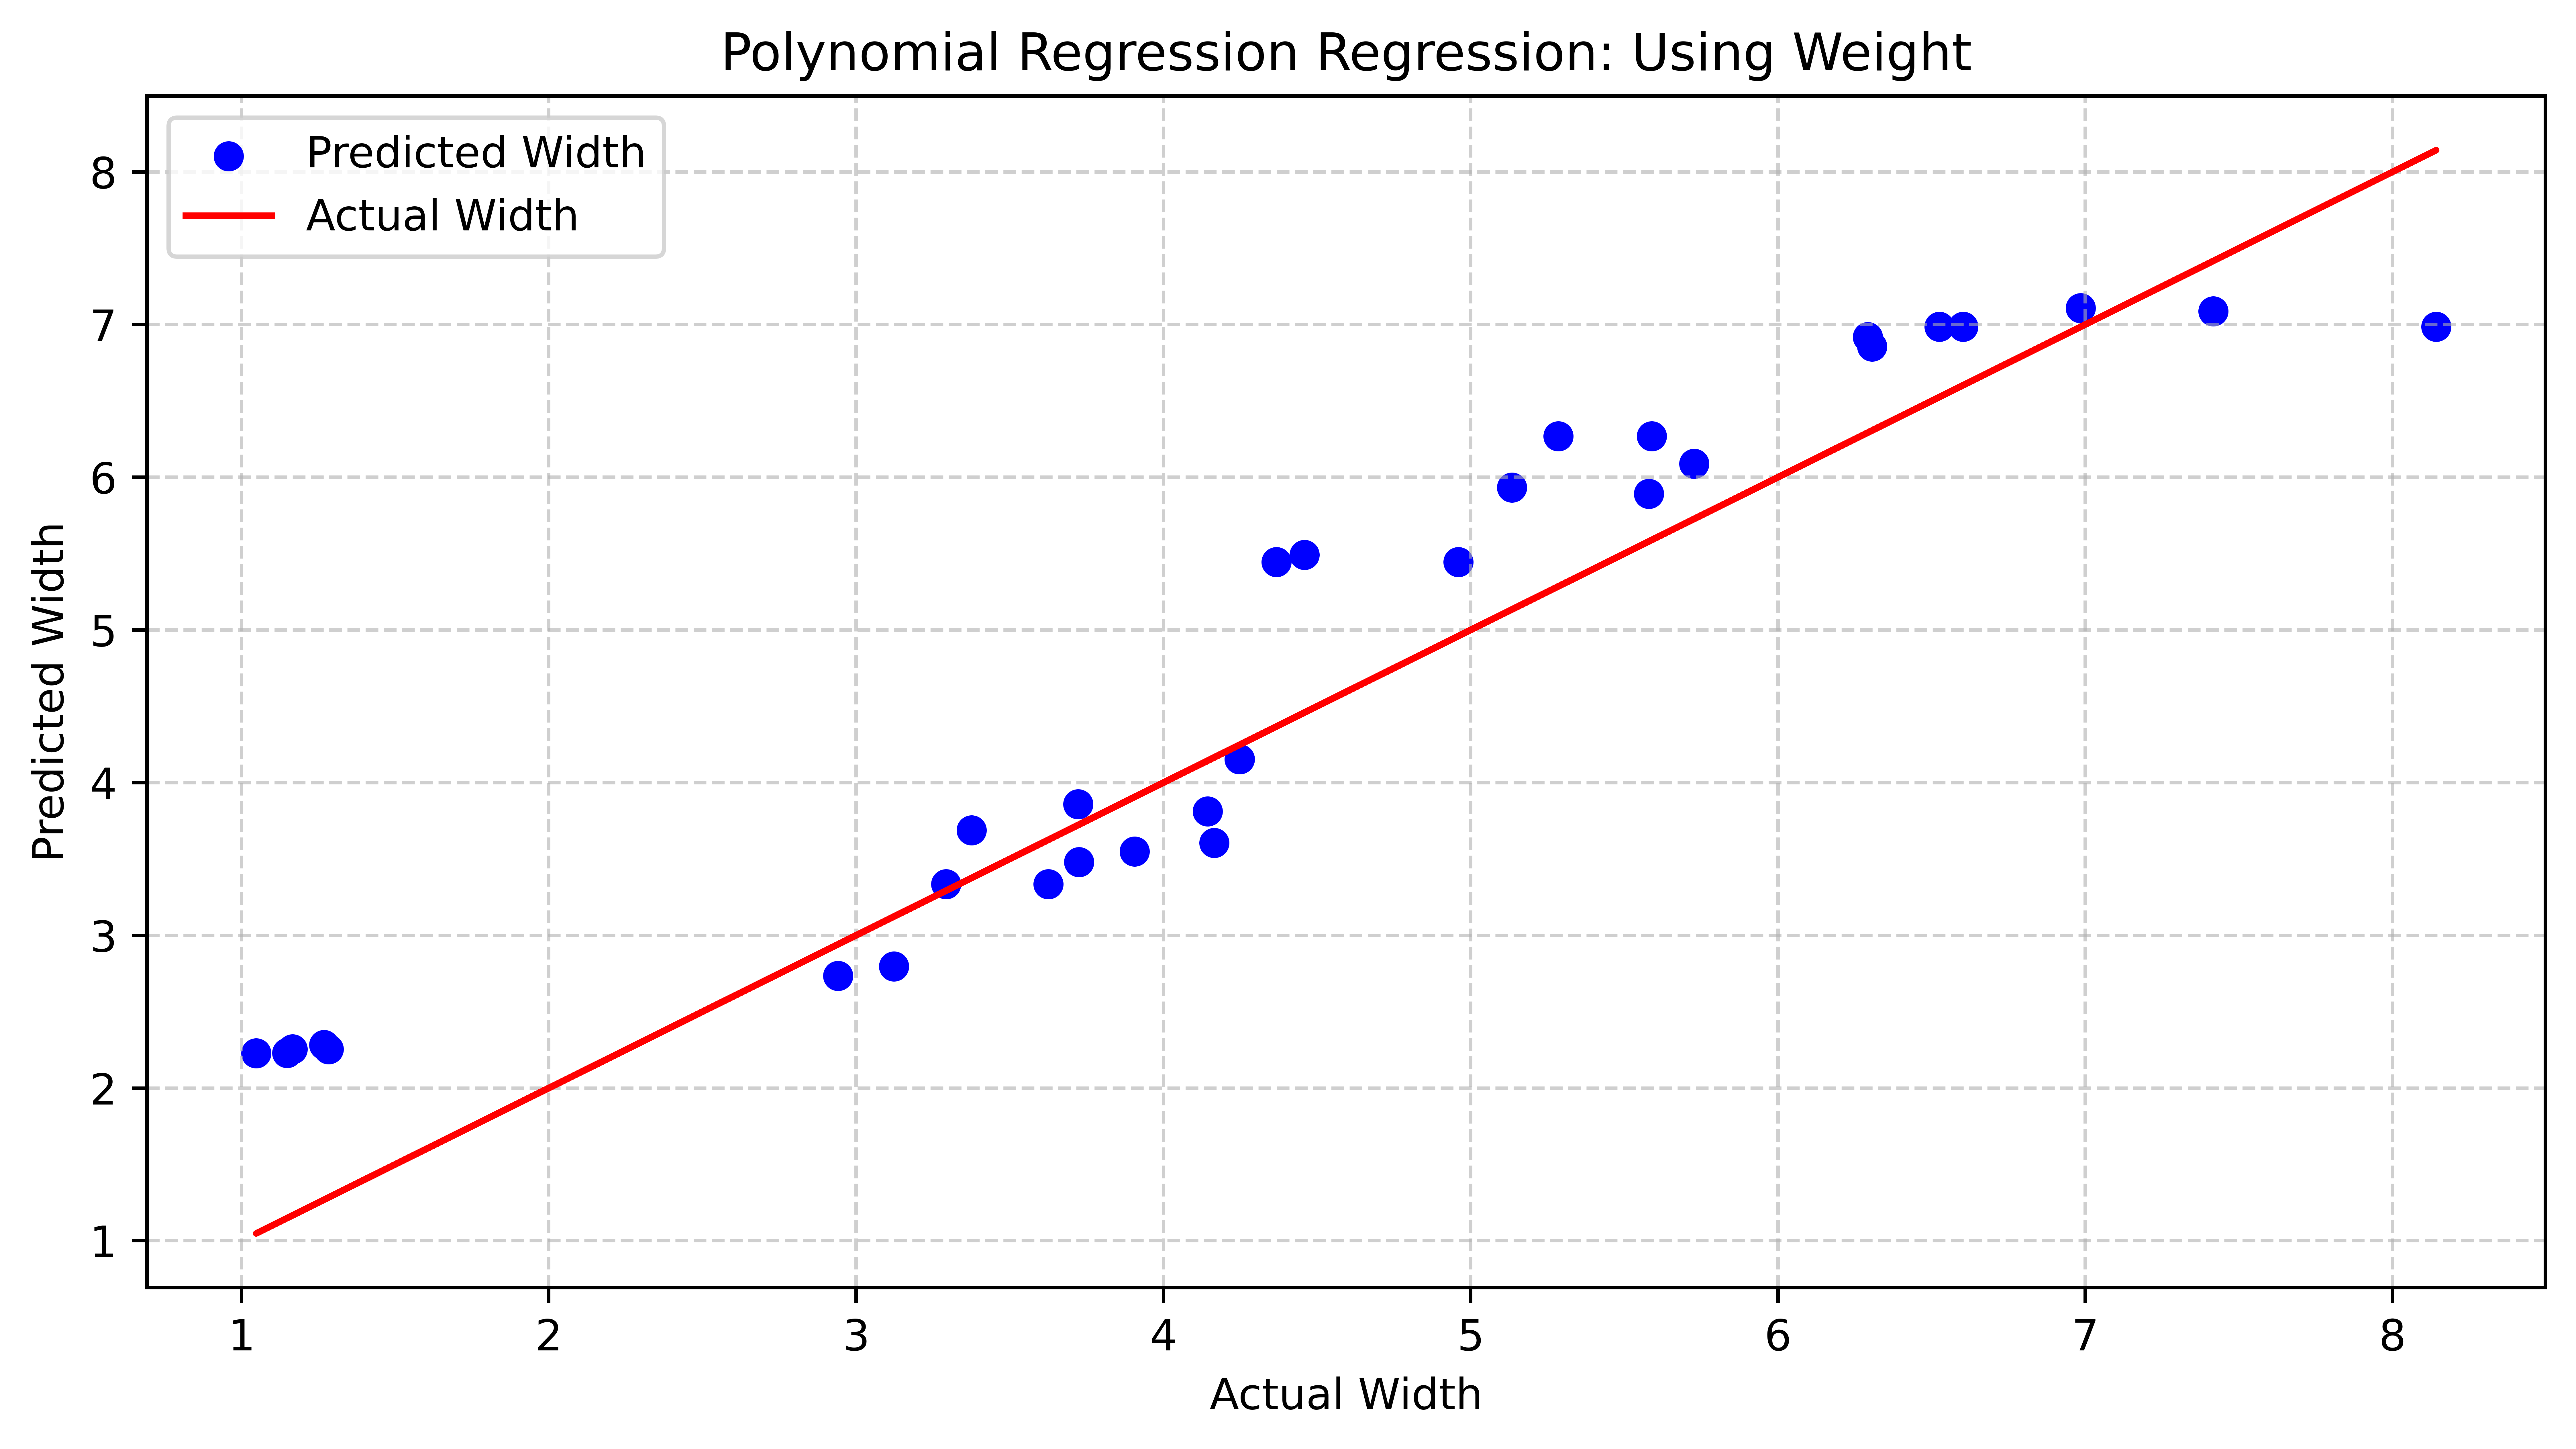

In [30]:
# Plotting the model
from plot_regression import plot_regression
plot_regression(
    y_test, y_pred,
    regression_type='Polynomial Regression',
    title="Using Weight")

### ---

Navigate:

| [$\leftarrow$ Linear Regression 2 ](n2_linear_regression_2.ipynb) | [Linear and Polynomial Regression $\rightarrow$](n4_linear_and_polynomial_regression.ipynb) |
| :-----------------------------------------------------------------: | :---------------------------------------------------------------: |
